In [6]:
# image_path = Path("/home/dika/Deep_learning/Torch/Deep_Learning_Unet_Torch/training/Test/image/image_*.tif")
# mask_path = Path("/home/dika/Deep_learning/Torch/Deep_Learning_Unet_Torch/training/Test/mask/mask_000.tif")

In [7]:
# Cell 1: Imports and Parameters
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path


In [8]:
# Parameters
image_folder = Path("/home/dika/Deep_learning/Torch/Deep_Learning_Unet_Torch/training/image")
output_folder = Path("/home/dika/Deep_learning/Torch/Deep_Learning_Unet_Torch/modification")
output_folder.mkdir(parents=True, exist_ok=True)
clip_min = 1
clip_max = 2500
fill_color = [12, 27, 11]
fig_size = (18, 24)
font_size = 12
max_images = 10
rows = 5
cols = 4
wspace = 0.01
hspace = 0.3

# Cell 2: Data Initialization
original_images = []
filled_images = []
titles = []

In [9]:
# Cell 3: Image Loading, Processing, and Saving Filled Output
for idx, input_path in enumerate(sorted(image_folder.glob("image_*.tif"))):
    if idx >= max_images:
        break

    original_bands_with_nan = []

    with rasterio.open(input_path) as src:
        transform = src.transform
        crs = src.crs
        profile = src.profile.copy()

        for band_index in range(1, 5):
            band = src.read(band_index).astype(np.float32)
            mask = src.read_masks(band_index) > 0
            band_with_nan = np.where(mask, band, np.nan)
            original_bands_with_nan.append(band_with_nan)

    rgb_orig = np.stack(original_bands_with_nan[:3], axis=0)

    rgb_orig_clipped = np.clip(rgb_orig, clip_min, clip_max)
    rgb_orig_scaled = ((rgb_orig_clipped - clip_min) / (clip_max - clip_min)) * 255.0
    rgb_orig_scaled = np.nan_to_num(rgb_orig_scaled, nan=0).astype(np.uint8)

    rgb_filled_scaled = rgb_orig_scaled.copy()
    mask_nan = np.any([np.isnan(b) for b in original_bands_with_nan[:3]], axis=0)
    for i, color_val in enumerate(fill_color):
        rgb_filled_scaled[i][mask_nan] = color_val

    original_images.append(np.moveaxis(rgb_orig_scaled, 0, -1))
    filled_rgb = np.moveaxis(rgb_filled_scaled, 0, -1)
    filled_images.append(filled_rgb)
    titles.append(input_path.name)

    # Save the filled RGB image
    filled_profile = profile.copy()
    filled_profile.update(count=3, dtype='uint8', compress='lzw')
    filled_output_path = output_folder / f"{input_path.stem}_filled.tif"
    with rasterio.open(filled_output_path, 'w', **filled_profile) as dst:
        dst.write(rgb_filled_scaled)

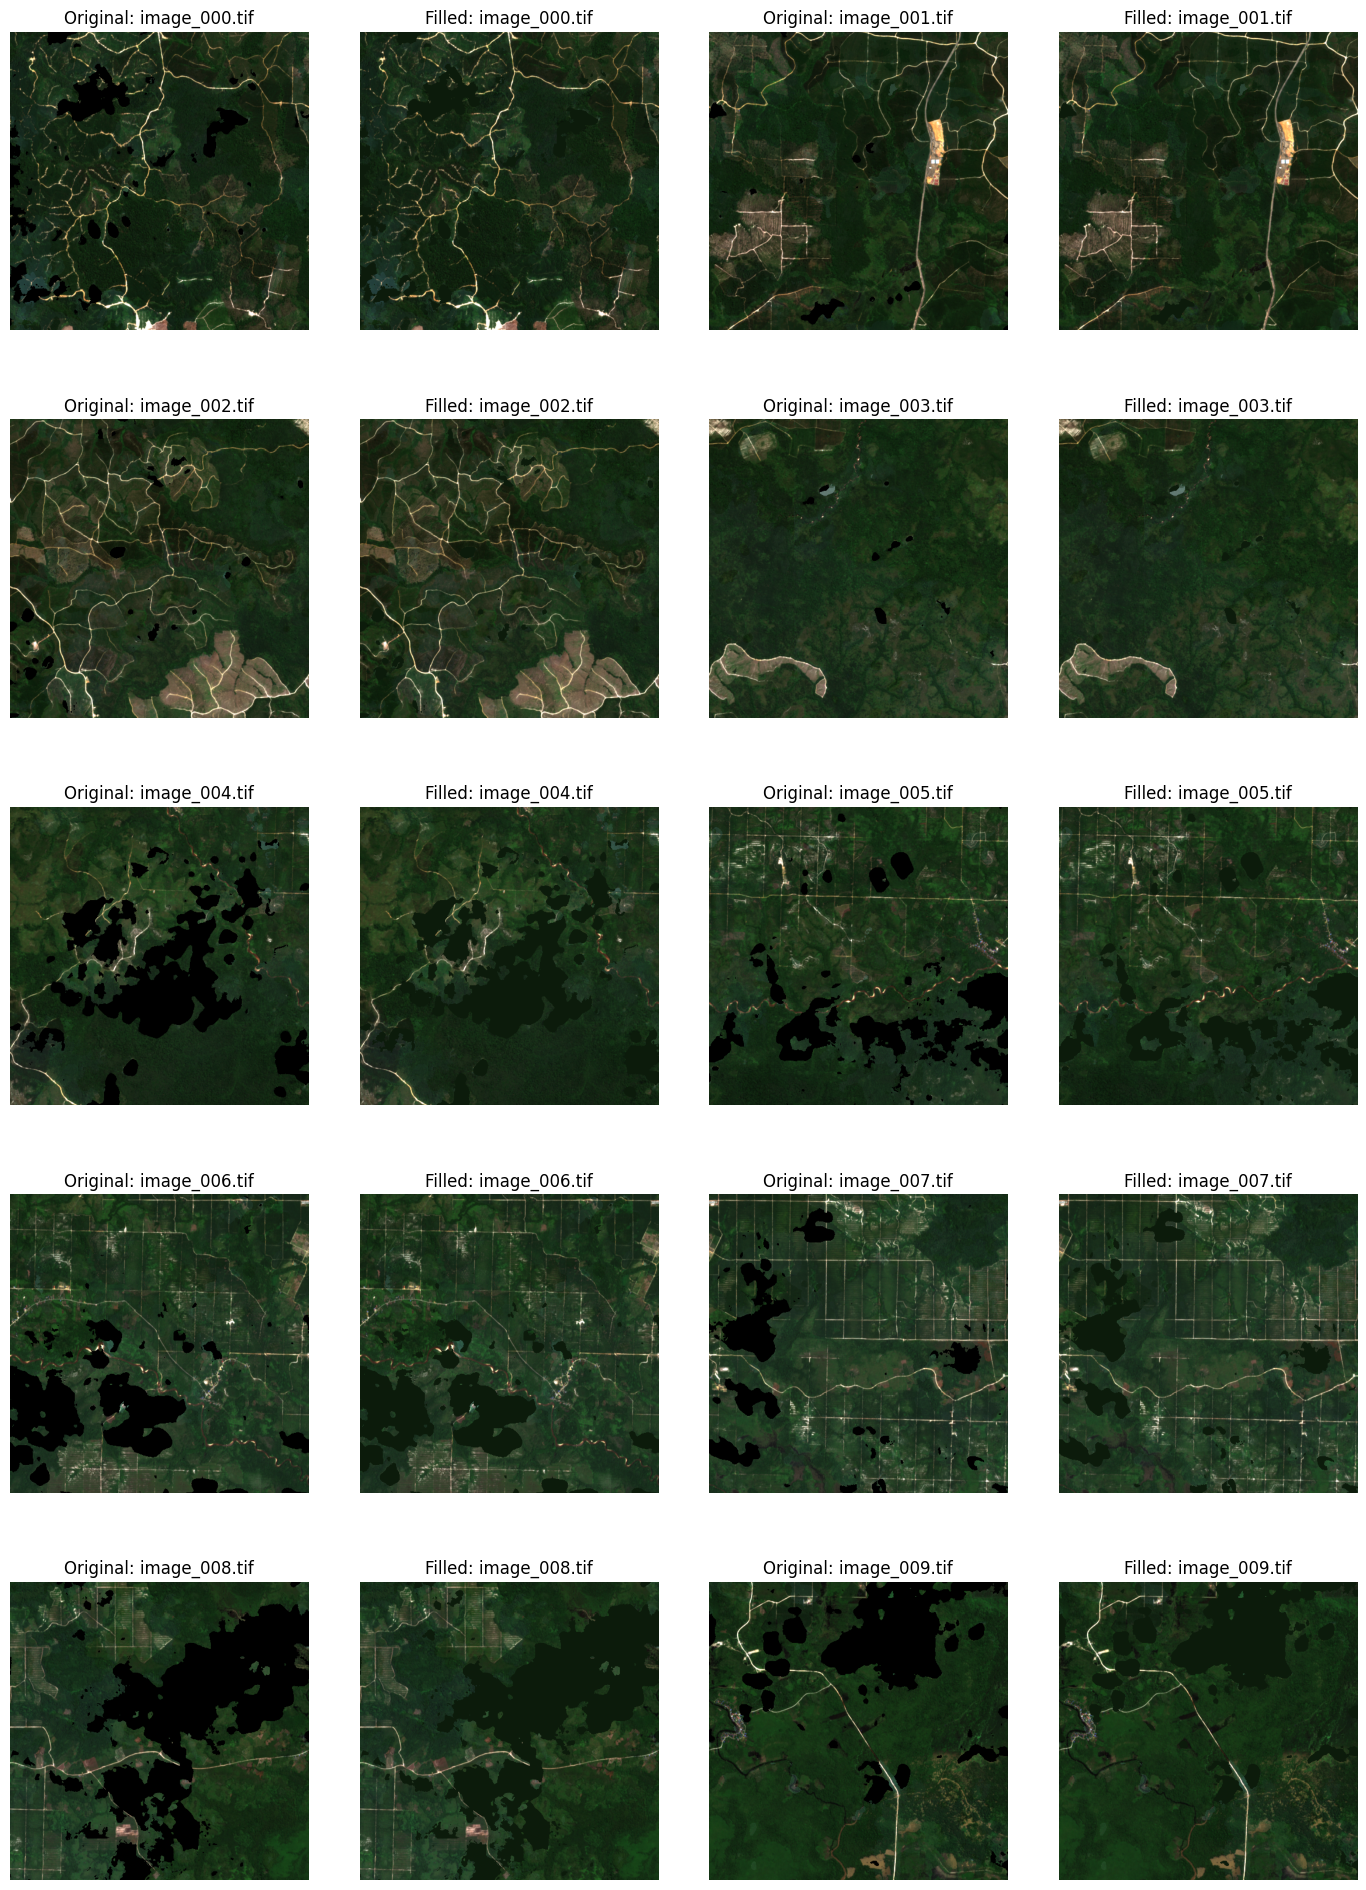

In [10]:
# Cell 4: Plotting
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=fig_size)
plt.subplots_adjust(wspace=wspace, hspace=hspace)

for i in range(rows * cols):
    ax = axes[i // cols, i % cols]
    img = original_images[i//2] if i % 2 == 0 else filled_images[i//2]
    label = "Original" if i % 2 == 0 else "Filled"
    ax.imshow(img)
    ax.set_title(f"{label}: {titles[i//2]}", fontsize=font_size)
    ax.axis('off')

plt.show()